In [1]:
import ROOT
from ROOT import gROOT, TCanvas, TF1, TFile, TTree, gRandom, TH1F

from ROOT import RooRealVar, RooFormulaVar, RooVoigtian, RooChebychev, RooArgList, \
                 RooArgSet, RooAddPdf, RooDataSet, RooCategory, RooSimultaneous, \
                 RooBreitWigner, RooCBShape, RooFFTConvPdf, RooGaussian,RooExponential, \
                 RooBinning, kRed, kBlue, kDotted,TString,RooAbsData, RooPlot, TCut, RooAbsData, RooFit , RooStats               

In [2]:
import sys
sys.path.append('/home/chasenberg/repos/')
from dopy.dolearn.sklearn_utils import plot_roc_curve, plot_classifier_output, plot_correlations

/opt/rh/miniconda/envs/py3root6/lib/python3.4/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os, sys, time, random
import ROOT 
from ROOT import TTree, TFile

# from root_numpy import root2array, rec2array, array2root

import pandas as pd
import numpy as np
import scipy 
import root_pandas as rp
import root_numpy as ry 

import pandas.core.common as com
from pandas.core.index import Index
from pandas.tools import plotting
from pandas.tools.plotting import scatter_matrix

from tqdm import tqdm_notebook

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.externals import joblib
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score

sys.path.append('/home/chasenberg/repos/')
sys.path.append('/home/chasenberg/repos/dopy')
from dopy import * 
from dopy.dolearn.sklearn_utils import plot_roc_curve, plot_classifier_output, plot_correlations
from dopy.dolearn.sklearn_utils import plot_feature_importances, plot_classifier_output, classify_unseen_data
#from dopy.sklearn_utils import plot_bdt_vars
from dopy.doplot.plotting import Plotter, Plot
from dopy.doanalysis.df_utils import add_min_max, add_eta 

Declare data directories and read files
--------------------------------------

In [14]:
#directories and files 
mc_dir = '/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/'
mc_file= 'Bd2JpsiKS_random.root'
mc_dir = os.path.join(mc_dir, mc_file)
data_dir = '/fhgfs/users/chasenberg/data/2015_2016_merged/jpsimumuks/'
data_file= 'Bd2JpsiKS_bestPV_sw.root'
data_dir = os.path.join(data_dir, data_file)

In [15]:
#Treename and cut for data
tree_data = 'Bd2JpsiKS'
cut_string_data = 'B0_FitDaughtersConst_M_flat<5450&B0_FitDaughtersConst_M_flat>5200'
#criteria and information for read in mc
cut_string_mc = 'B0_FitDaughtersConst_M_flat<5450&B0_FitDaughtersConst_M_flat>5200'
tree_mc = 'Bd2JpsiKS'

Load data from ROOT files
-------------------------------------------------------

In [16]:
signal_dataframe_wrongPV  = rp.read_root(mc_dir,key=tree_mc,where=cut_string_mc, flatten=False)
signal_dataframe_wrongPV  = signal_dataframe_wrongPV.replace([np.inf, -np.inf], np.nan)
signal_dataframe_wrongPV  = signal_dataframe_wrongPV.dropna()

In [17]:
real_dataframe_wrongPV = rp.read_root(data_dir,key=tree_data,where=cut_string_data, flatten=False)
real_dataframe_wrongPV = real_dataframe_wrongPV.replace([np.inf, -np.inf], np.nan)
real_dataframe_wrongPV = real_dataframe_wrongPV.dropna()
#real_dataframe_wrongPV = pd.concat([real_dataframe_wrongPV_2015])'''

## Plot control variable "pz_pull"


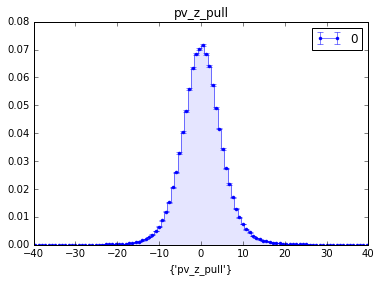

In [18]:
plot_var = ['pv_z_pull']
plot_names = plot_var

plotter = Plotter('/home/chasenberg/plots/wrong_pv/')
plotter.create_plots(signal_dataframe_wrongPV, plot_var)
plotter['pv_z_pull'].set_range(-40,40)#-5000,2000
#plotter['pv_z_pull'].set_log_y()
plotter.plot()

Declare bdt features and correlation matrix  
---------------------------------------------------------------------------------

In [19]:
bdt_features = [  
       'B0_FitPVConst_IPCHI2_flat', 
       'B0_FitPVConst_chi2_flat',
       'B0_FitPVConst_MinIPCHI2anyPV_flat',
       #'B0_FitPVConst_J_psi_1S_MinIPCHI2anyPV_flat',
       'B0_FitPVConst_J_psi_1S_IPCHI2_flat',
       #'B0_FitPVConst_KS0_IPCHI2_flat',
       #'B0_FitPVConst_KS0_MinIPCHI2anyPV_flat',
       'B0_FitDaughtersConst_KS0_IP_flat',
       'muminus_MINIPCHI2',
       'muplus_MINIPCHI2', 
       'B0_FitPVConst_PV_Z_flat',  
      # 'B0_FitPVConst_Z_flat',
       'B0_FitDaughtersConst_J_psi_1S_min_PT'
]

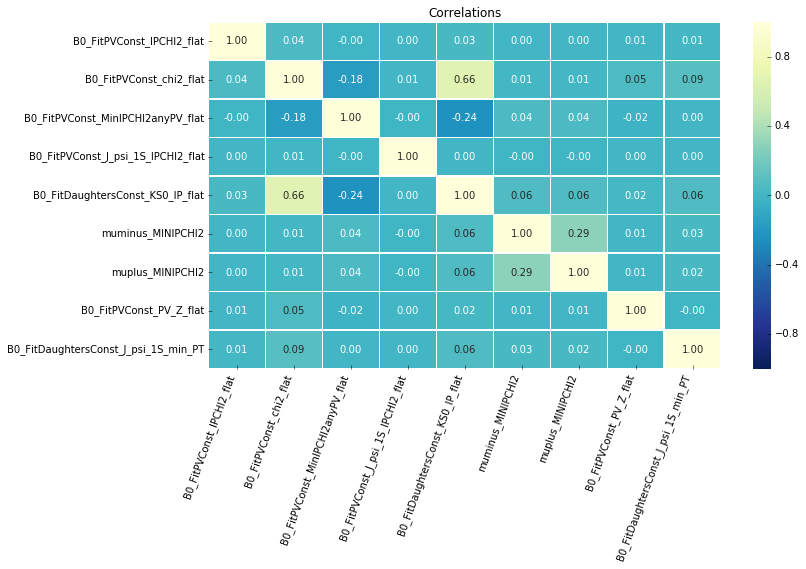

"plot_correlations(signal_dataframe_wrongPV[bdt_features], annot=True, fmt='.2f')\nplt.savefig('/home/chasenberg/plots/wrong_pv/correlation_mc.png')\nplt.show()\nprint('Done!')"

In [20]:
plt.figure(figsize=(12,8))
plot_correlations(signal_dataframe_wrongPV[bdt_features], annot=True, fmt='.2f')
plt.savefig('/home/chasenberg/plots/wrong_pv/correlation_data.png')
plt.show()
plt.figure(figsize=(12,8))
'''plot_correlations(signal_dataframe_wrongPV[bdt_features], annot=True, fmt='.2f')
plt.savefig('/home/chasenberg/plots/wrong_pv/correlation_mc.png')
plt.show()
print('Done!')'''

Plot sWeighted BDT variables against MC
----------------------------------------------------------------------------------

In [21]:
variables = real_dataframe_wrongPV.columns.tolist().remove('signal_sw')

In [22]:
real_dataframe_wrongPV.columns

Index(['B0_TAGDECISION_OS', 'B0_TAGOMEGA_OS', 'B0_OS_Muon_DEC',
       'B0_OS_Muon_PROB', 'B0_OS_Electron_DEC', 'B0_OS_Electron_PROB',
       'B0_OS_Kaon_DEC', 'B0_OS_Kaon_PROB', 'B0_OS_Charm_DEC',
       'B0_OS_Charm_PROB', 'B0_VtxCharge_DEC', 'B0_VtxCharge_PROB',
       'B0_SS_PionBDT_DEC', 'B0_SS_PionBDT_PROB', 'B0_SS_Proton_DEC',
       'B0_SS_Proton_PROB', 'B0_FitDaughtersConst_M_flat',
       'B0_FitDaughtersConst_chi2_flat', 'B0_FitDaughtersConst_IPCHI2_flat',
       'B0_FitDaughtersConst_J_psi_1S_IP_flat',
       'B0_FitDaughtersConst_KS0_P1_PT_flat',
       'B0_FitDaughtersConst_KS0_P0_PT_flat',
       'B0_FitDaughtersConst_KS0_decayLength_flat',
       'B0_FitDaughtersConst_KS0_IP_flat',
       'B0_FitDaughtersConst_KS0_P0_IPCHI2_flat',
       'B0_FitDaughtersConst_J_psi_1S_IPCHI2_flat', 'idxPV',
       'B0_FitDaughtersConst_KS0_P1_IPCHI2_flat',
       'B0_FitDaughtersConst_J_psi_1S_P0_PT_flat',
       'B0_FitDaughtersConst_J_psi_1S_P1_PT_flat',
       'B0_FitPVConst_KS0_tau_

## sWeighted data against mc

In [38]:
for feature in bdt_features:
    print(feature)

B0_FitPVConst_IPCHI2_flat
B0_FitPVConst_chi2_flat
B0_FitPVConst_MinIPCHI2anyPV_flat
B0_FitPVConst_J_psi_1S_IPCHI2_flat
B0_FitDaughtersConst_KS0_IP_flat
muminus_MINIPCHI2
muplus_MINIPCHI2
B0_FitPVConst_PV_Z_flat
B0_FitDaughtersConst_J_psi_1S_min_PT


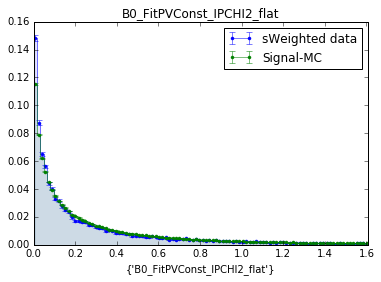

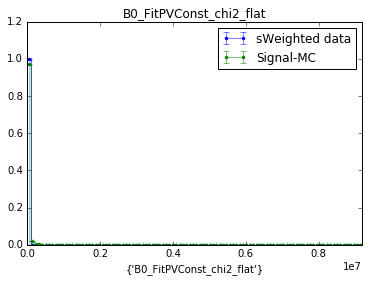

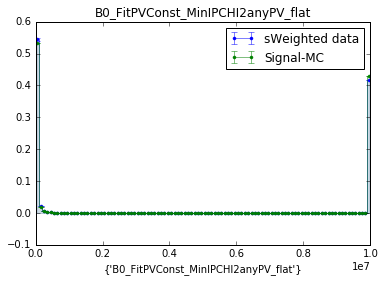

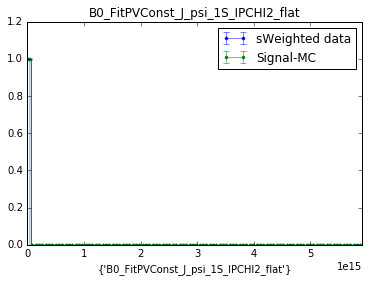

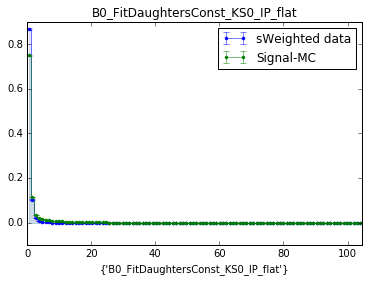

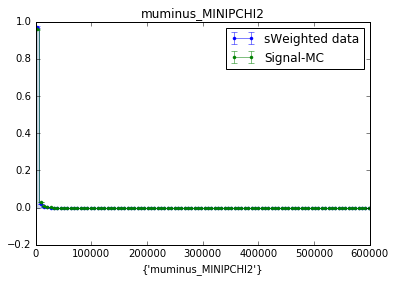

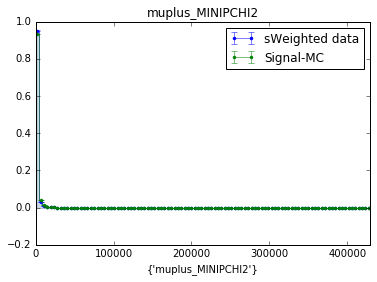

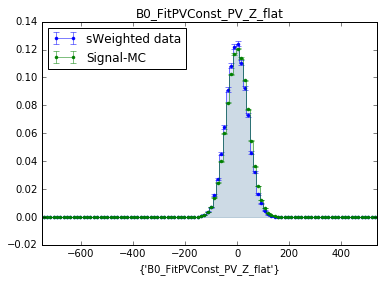

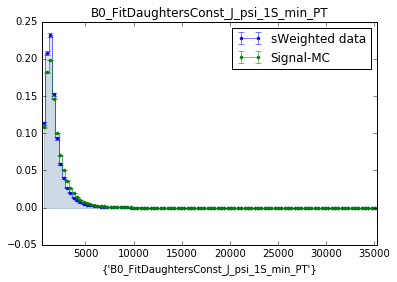

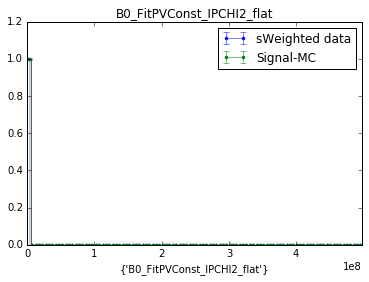

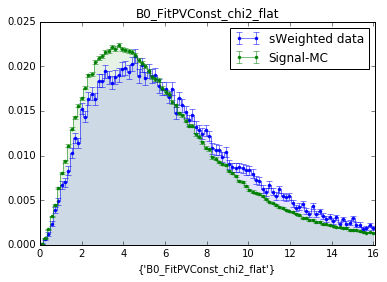

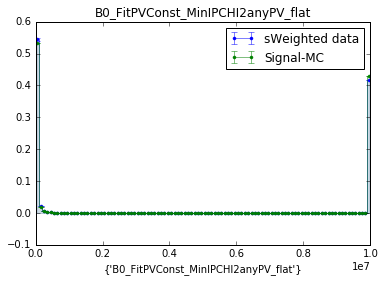

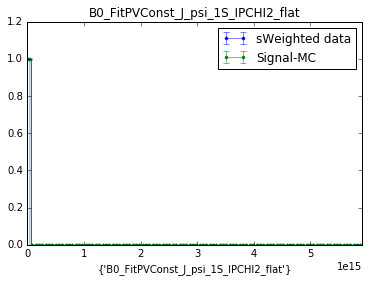

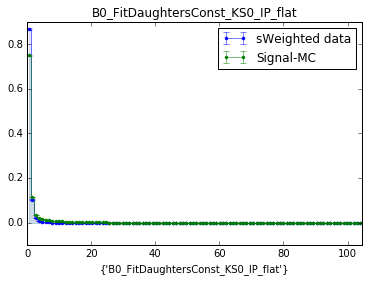

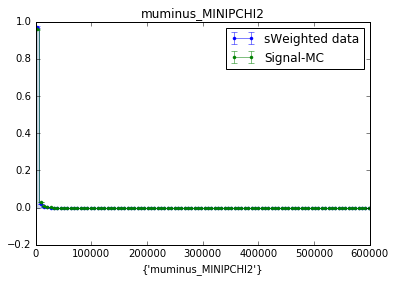

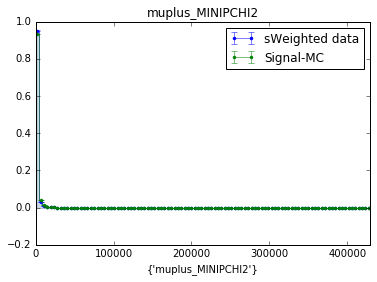

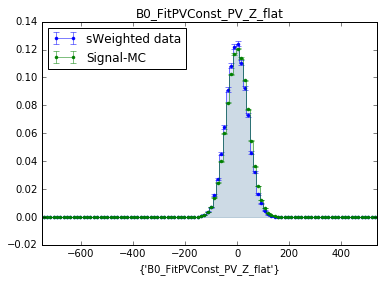

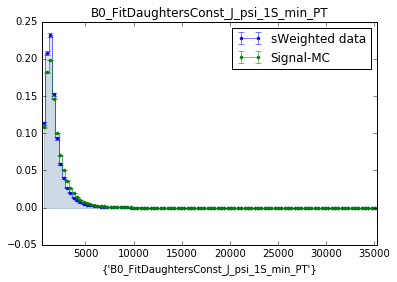

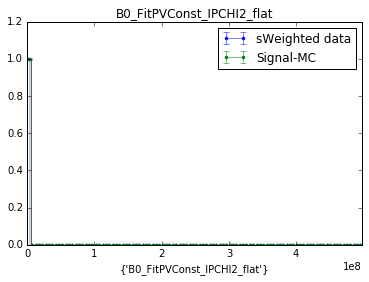

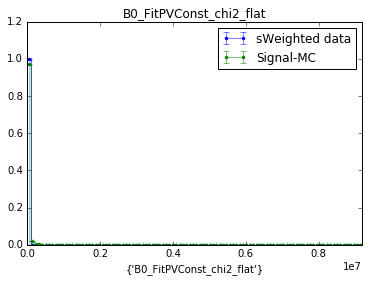

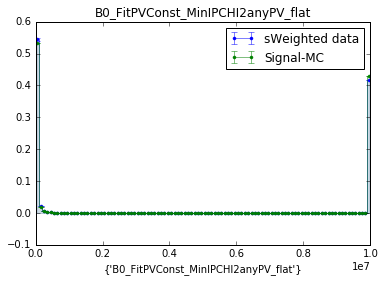

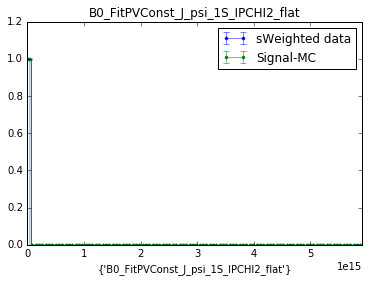

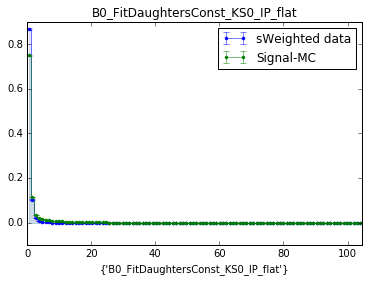

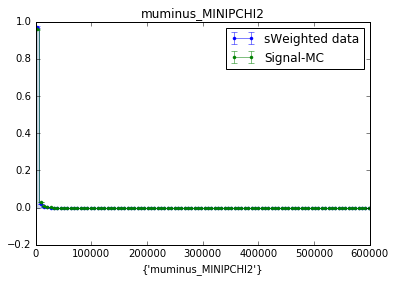

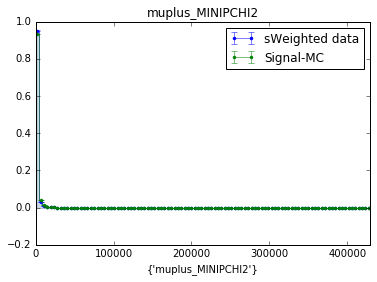

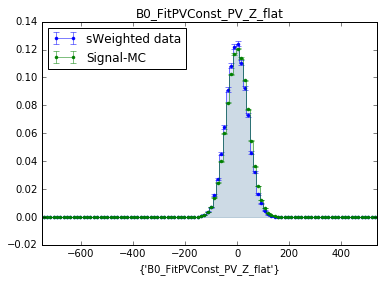

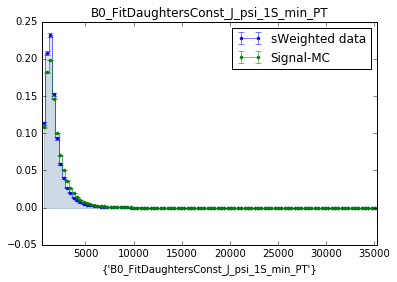

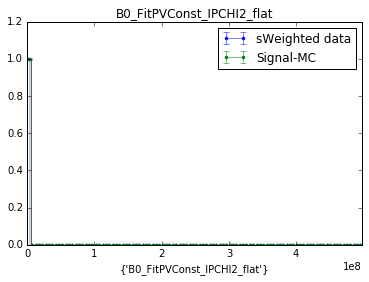

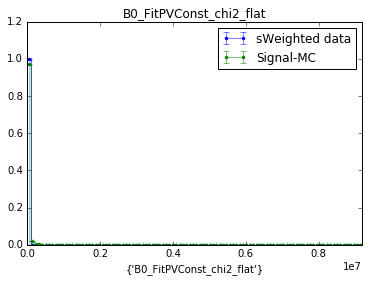

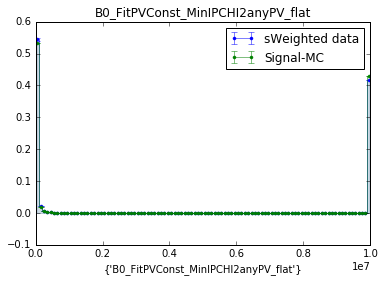

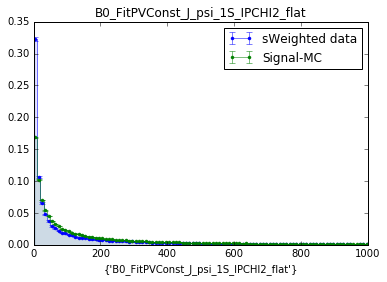

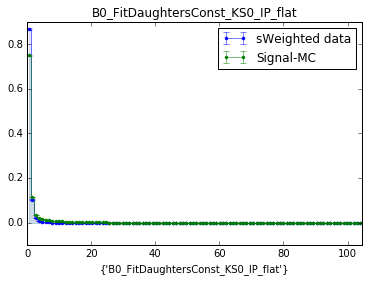

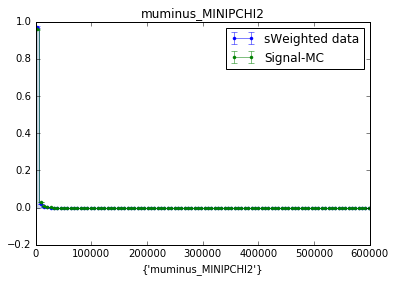

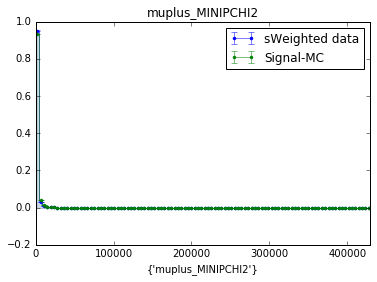

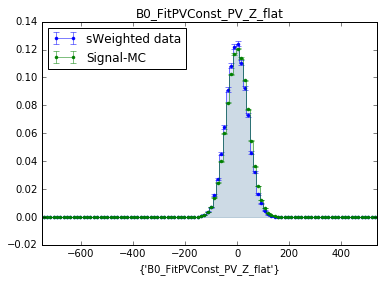

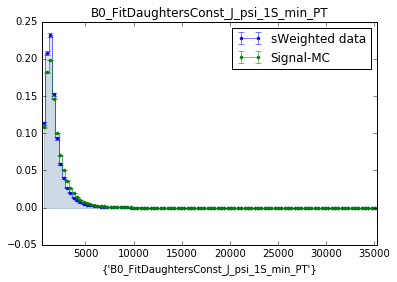

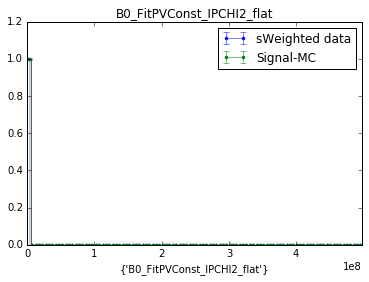

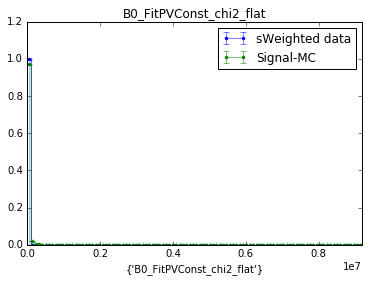

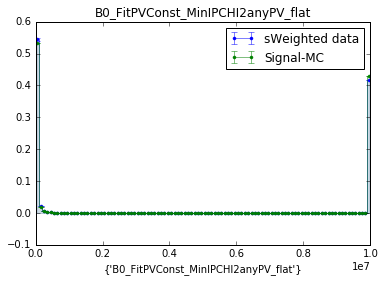

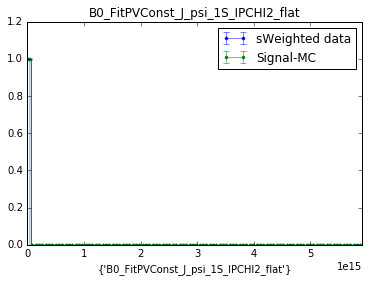

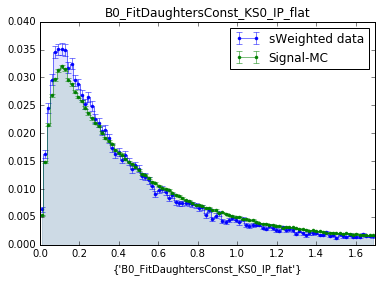

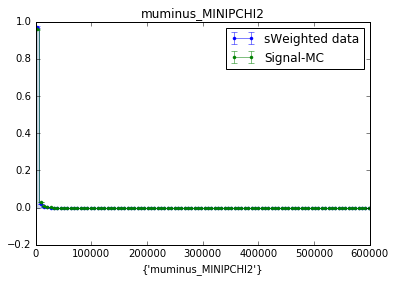

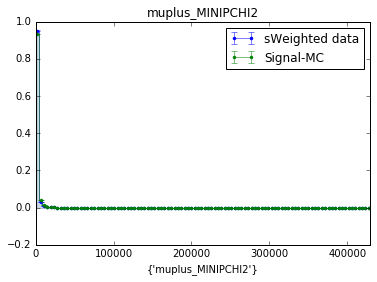

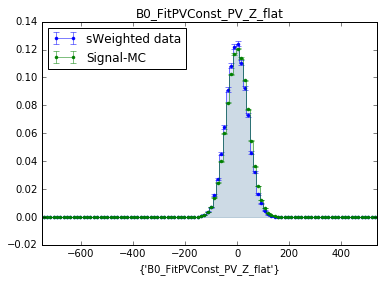

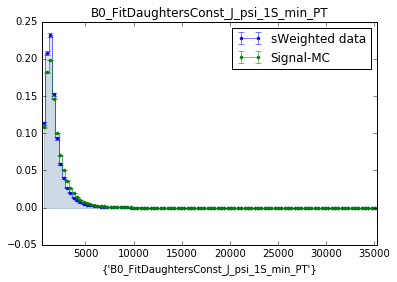

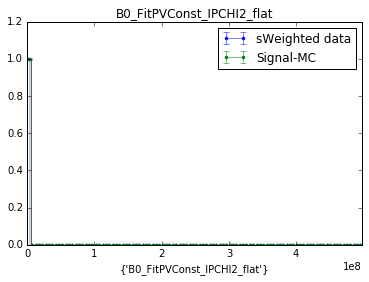

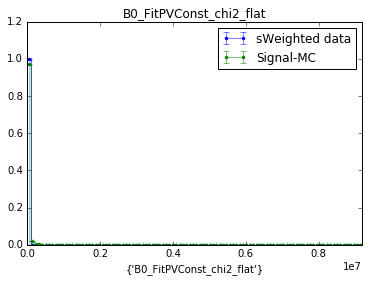

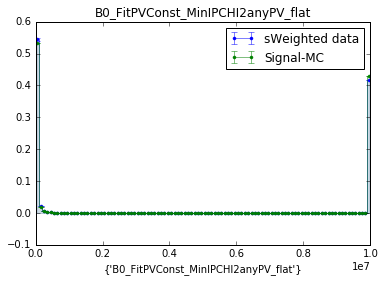

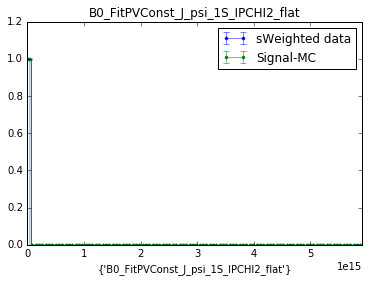

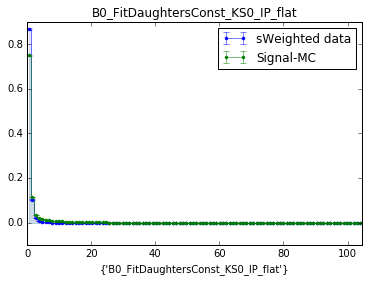

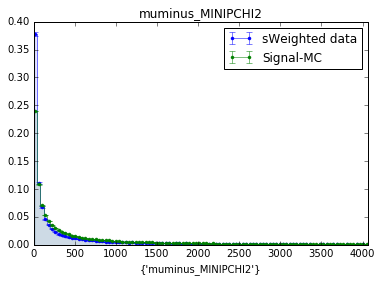

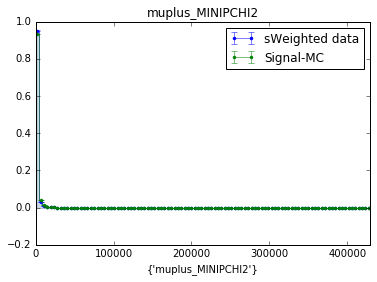

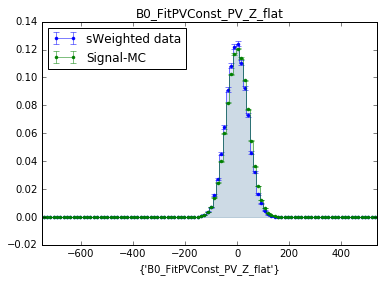

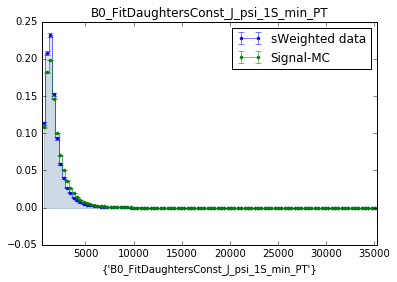

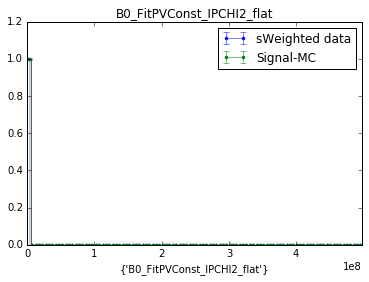

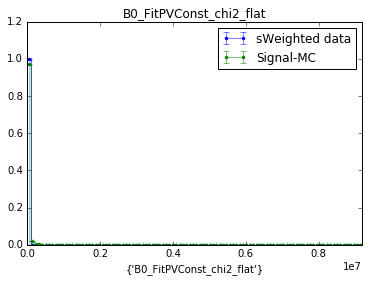

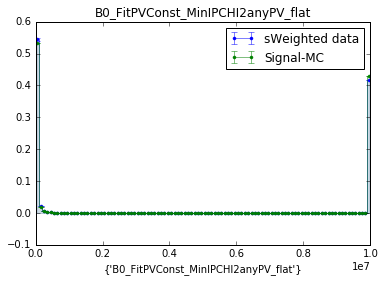

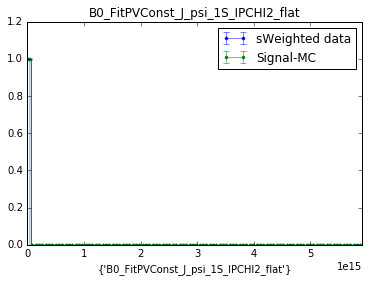

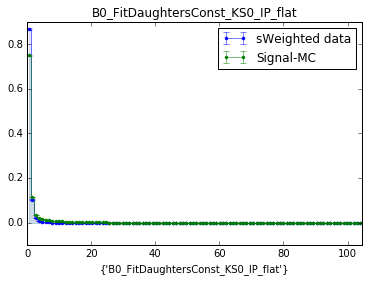

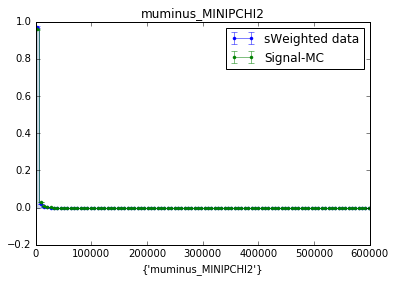

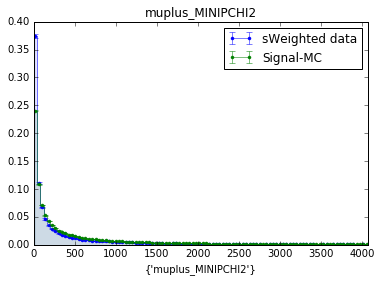

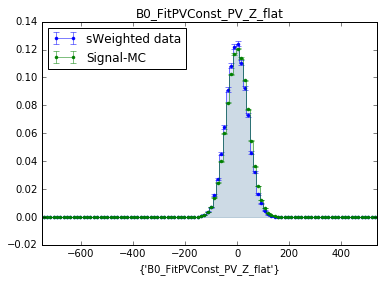

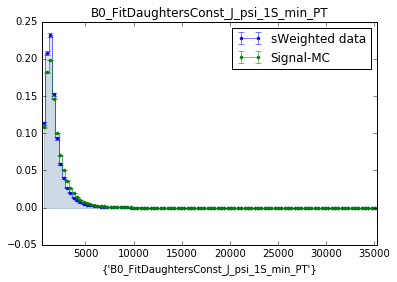

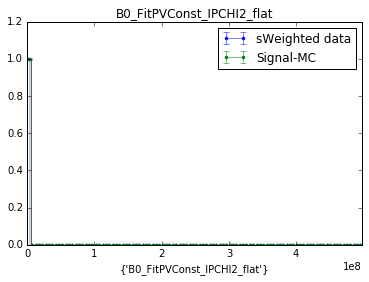

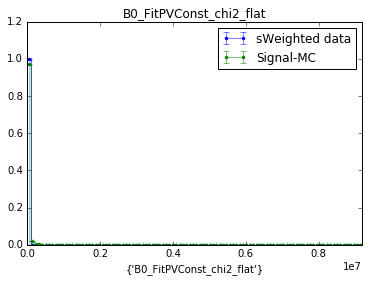

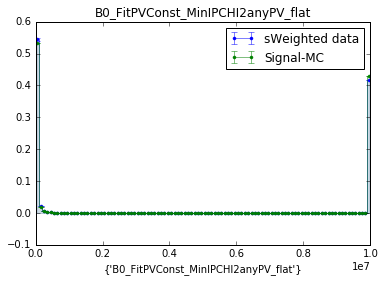

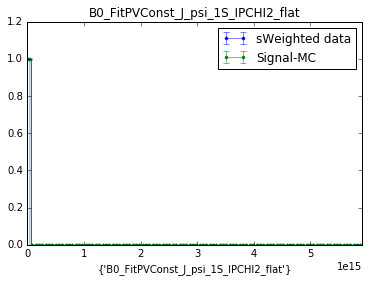

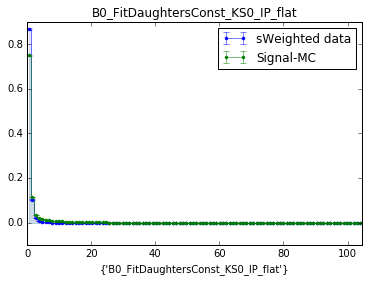

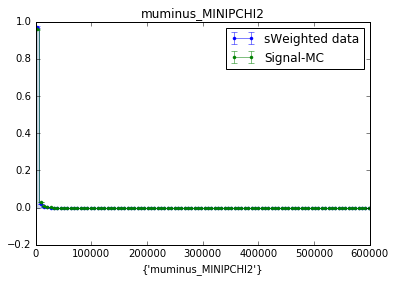

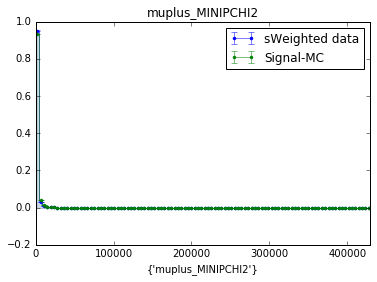

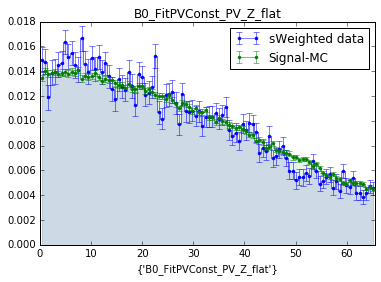

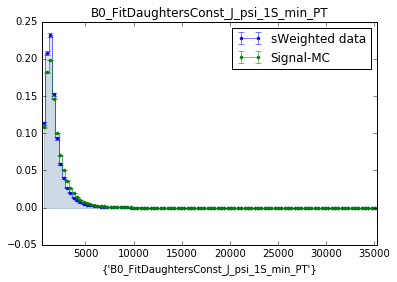

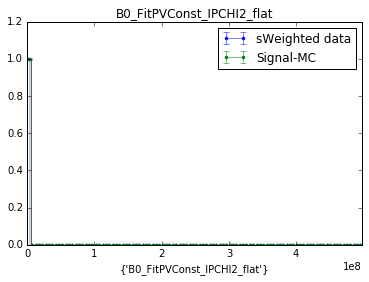

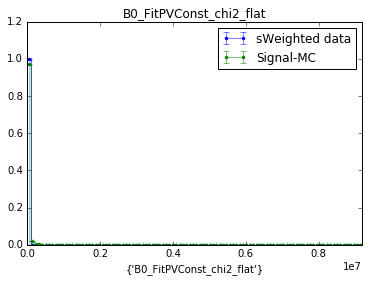

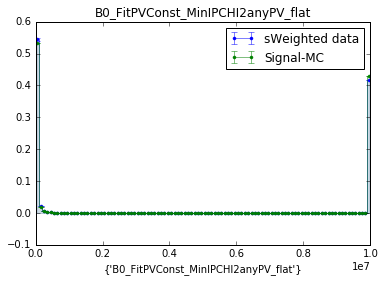

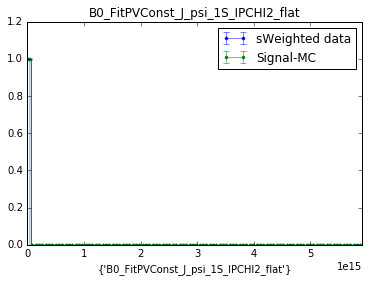

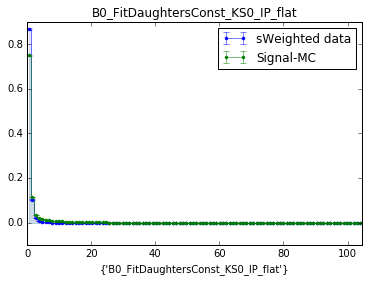

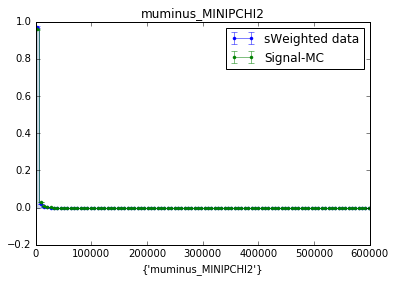

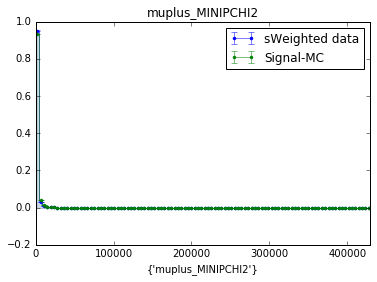

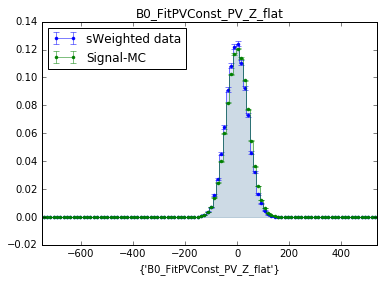

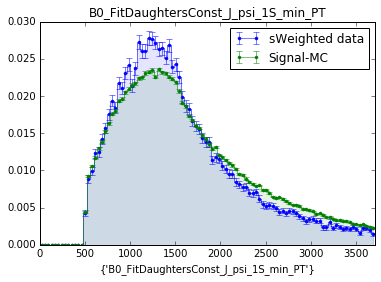

In [40]:
#Check bdt-variables 
mc_weight = np.ones(signal_dataframe_wrongPV.shape[0])
signal_dataframe_wrongPV['mc_weight'] = mc_weight

for feature in bdt_features:
    plotter = Plotter('/home/chasenberg/plots/wrong_pv/mc_agreement/')
    plotter.create_plots([real_dataframe_wrongPV,signal_dataframe_wrongPV], bdt_features, weightvars=['signal_sw','mc_weight']
    ,component_labels=['sWeighted data','Signal-MC'])
    plotter[feature].set_range(0,real_dataframe_wrongPV[feature].quantile(0.95))
    #plotter[feature].set_range(0,20)
    plotter.plot()

Train GradienBoost classifier
====================================================================

In [24]:
correct_pvs = signal_dataframe_wrongPV.query('abs(pv_z_pull)<20')
incorrect_pvs = signal_dataframe_wrongPV.query('abs(pv_z_pull)>20')
flags = np.array([1]*len(correct_pvs)+[0]*len(incorrect_pvs))
dataframe = pd.concat([correct_pvs,incorrect_pvs])

In [25]:
correct_pvs.shape, incorrect_pvs.shape,dataframe.shape

((496785, 69), (4788, 69), (501573, 69))

In [26]:
#Apply Track Type cuts piminus_TRACK_Type

In [27]:
train_dataframe, test_dataframe, train_flags, test_flags = train_test_split(
                                                            dataframe[bdt_features], flags, test_size=0.5, random_state=42)
classifier = GradientBoostingClassifier(max_depth=3, verbose=1,n_estimators=200,learning_rate=0.03)
classifier.fit(train_dataframe, train_flags)

      Iter       Train Loss   Remaining Time 
         1           0.1056           52.35s
         2           0.1042           52.09s
         3           0.1030           51.89s
         4           0.1020           51.69s
         5           0.1011           51.40s
         6           0.1004           51.34s
         7           0.0997           51.29s
         8           0.0991           50.91s
         9           0.0986           50.35s
        10           0.0982           50.04s
        20           0.0951           47.65s
        30           0.0935           45.11s
        40           0.0925           43.16s
        50           0.0917           40.27s
        60           0.0909           37.51s
        70           0.0903           35.01s
        80           0.0898           32.44s
        90           0.0891           29.85s
       100           0.0887           27.16s
       200           0.0864            0.00s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.03, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=None,
              subsample=1.0, verbose=1, warm_start=False)

In [28]:
dataframe.shape

(501573, 69)

Classifier performance
-----------------------

In [29]:
classifier.score(test_dataframe, test_flags)

0.99045803809607358

In [30]:
importances = classifier.feature_importances_
print("Features sorted by their score:" )
importances_sorted = sorted(zip(importances, dataframe.columns), reverse=True)
for val,name in importances_sorted:
    print('{}: {:.4f}'.format(name, val))

Features sorted by their score:
B0_FitDaughtersConst_chi2_flat: 0.3362
B0_FitDaughtersConst_status_flat: 0.2431
B0_FitDaughtersConst_J_psi_1S_P1_PT_flat: 0.0880
B0_FitDaughtersConst_J_psi_1S_IPCHI2_flat: 0.0744
B0_FitDaughtersConst_J_psi_1S_P0_PT_flat: 0.0665
B0_FitDaughtersConst_J_psi_1S_MinIPCHI2anyPV_flat: 0.0606
B0_FitDaughtersConst_M_flat: 0.0582
B0_FitDaughtersConst_IPCHI2_flat: 0.0453
B0_FitDaughtersConst_PT_flat: 0.0277


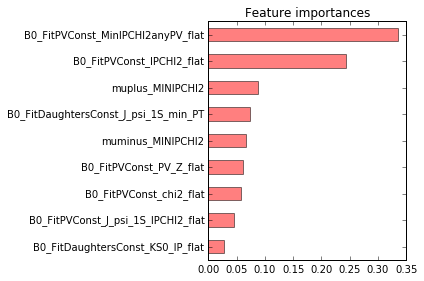

In [31]:
#Plot feature importances 
plot_feature_importances(classifier,dataframe[bdt_features])
plt.savefig('/home/chasenberg/plots/wrong_pv/feature_importance.png', bbox_inches='tight')

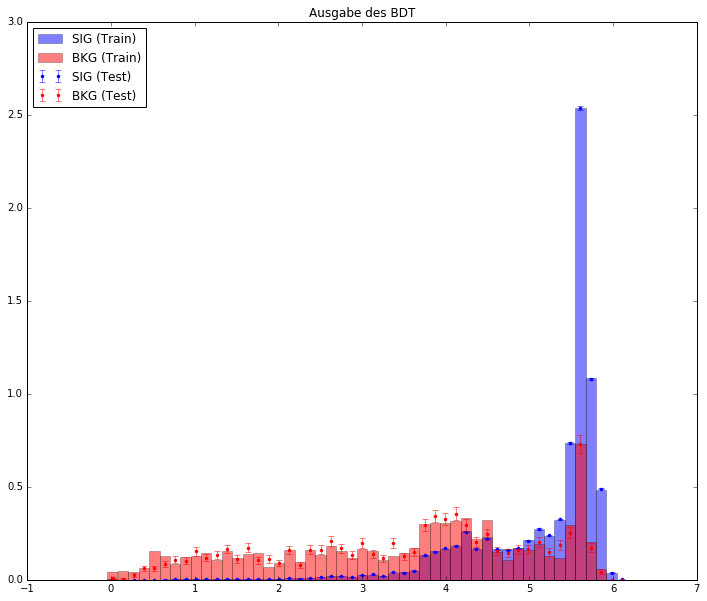

In [32]:
plt.figure(figsize=(12,10))
plot_classifier_output(classifier, train_dataframe, train_flags, test_dataframe, test_flags, title='Ausgabe des BDT',bins=50)
plt.savefig('/home/chasenberg/plots/wrong_pv/overtraining.png')
plt.show()


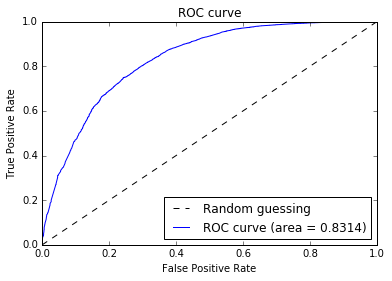

In [33]:
plot_roc_curve(classifier, test_dataframe, test_flags)
plt.savefig('/home/chasenberg/plots/wrong_pv/roc_curve.png')




Classify unseen Data
============================================

In [34]:
#apply classifier to data and MC
classify_unseen_data([classifier], dataframe, bdt_features, 'BDTresponse_wrongPV')

Check efficiencies of classifier cuts
-------------------------------

In [35]:
cut = 'BDTresponse_wrongPV>4'
efficiency = dataframe.query(cut).shape[0] / dataframe.shape[0]
print('The efficiency of the cut is:')
print(efficiency,dataframe.shape[0])
#compare to best PV selection
efficiency = dataframe.query('idxPV==0').shape[0] / dataframe.shape[0]
print('The efficiency of the bestPV selection is:')
print(efficiency,dataframe.shape[0])



The efficiency of the cut is:
0.9015596932051765 501573
The efficiency of the bestPV selection is:
0.8858869994995744 501573


In [36]:
dataframe.query(cut).to_root('/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/Bd2JpsiKS_pv_selected.root',key='Bd2JpsiKS')